# Oracoli quantistici - *Quantum Oracles*

## Oracoli booleani

Gli oracoli booleani sono delle black box tali che, dati in input uno stato $|x\rangle$ e uno stato $|00\dots00\rangle$, ritornano $|x\rangle$ e $|f(x)\rangle$.


In [20]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram

import numpy as np
from BoredQiskit import FastQiskit as fq

### $f(x) = x$

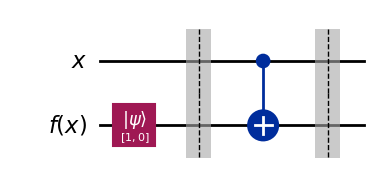

In [3]:
x = QuantumRegister(1, name='x')
fx = QuantumRegister(1, name='f(x)')
qc = QuantumCircuit(x, fx)

qc.initialize([1,0], 1)
qc.barrier()

qc.cx(0,1)
qc.barrier()

qc.draw('mpl')

### $f(x) = \lnot x$

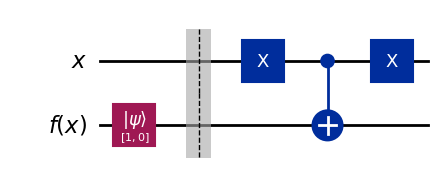

In [4]:
x = QuantumRegister(1, name='x')
fx = QuantumRegister(1, name='f(x)')
qc = QuantumCircuit(x, fx)

qc.initialize([1,0], 1)
qc.barrier()

qc.x(0)
qc.cx(0,1)
qc.x(0)

qc.draw('mpl')

### $f(x_1 x_2) = x_1 \land x_2$

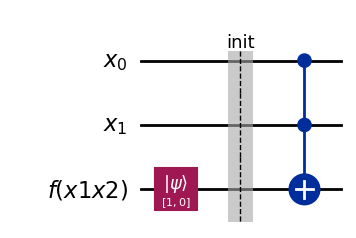

In [5]:
x = QuantumRegister(2, name='x')
fx = QuantumRegister(1, name='f(x1x2)')
qc = QuantumCircuit(x,fx)

qc.initialize([1,0], 2)
qc.barrier(label='init')

qc.ccx(0,1,2)

qc.draw('mpl')

### $f(x) = 0$ (funzione costante 0)

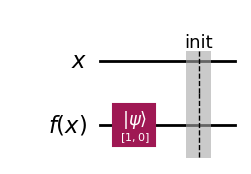

In [6]:
x = QuantumRegister(1, name='x')
fx = QuantumRegister(1, name='f(x)')
qc = QuantumCircuit(x,fx)

qc.initialize([1,0], 1)
qc.barrier(label='init')

qc.draw('mpl')

### $f(x) = 1$ (funzione costante 1)

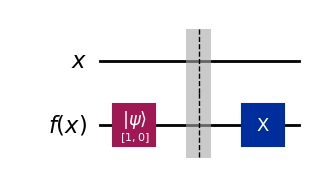

In [7]:
x = QuantumRegister(1, name='x')
fx = QuantumRegister(1, name='f(x)')
qc = QuantumCircuit(x,fx)

qc.initialize([1,0], 1)
qc.barrier()
qc.x(1)

qc.draw('mpl')

### $f(x_1,x_2, \dots,x_n) = x_1 \oplus x_2 \oplus \dots \oplus x_n$ (XOR)

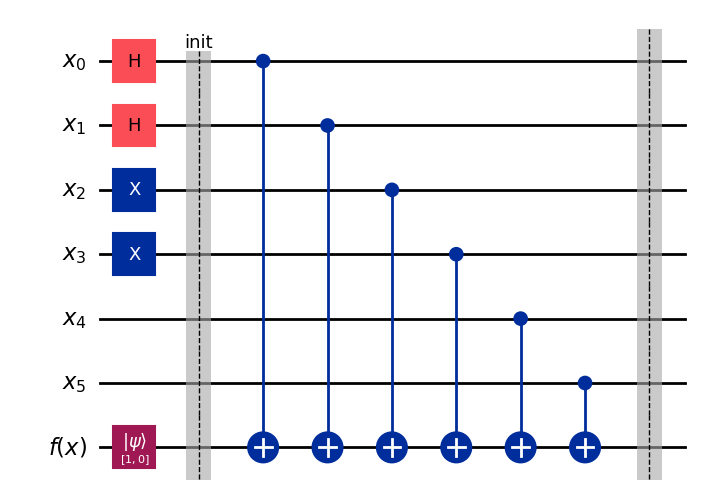

In [8]:
def xor(x):
    n = len(x)
    qrx = QuantumRegister(n, name='x')
    fx = QuantumRegister(1, name='f(x)')
    qc = QuantumCircuit(qrx,fx)
    qc.initialize([1,0], n)
    for i in range(n):
        if x[i] == '1':
            qc.x(i)
        if x[i] == '+':
            qc.h(i)
    qc.barrier(label='init')

    qc.cx(range(n), n)
    qc.barrier()
    return qc

xor('++1100').draw('mpl')

### Esercizio 1: $f(x_1, \dots, x_n, y_1, \dots, y_n) = 1$ se $x_i = y_i \quad \forall i \in [0,n]$

In [9]:
def string_eq(x,y):
    if (len(x) != len(y)):
        print("error")
        return
    
    n = len(x)
    xr = QuantumRegister(n, 'x')
    yr = QuantumRegister(n, 'y')
    ar = QuantumRegister(n, 'anc')
    out = QuantumRegister(1, 'out')
    #crx = ClassicalRegister(n, 'crx')
    #cry = ClassicalRegister(n, 'cry')
    cro = ClassicalRegister(1, 'c')
    ##qc = QuantumCircuit(xr, yr, ar, out, crx, cry, cro)
    qc = QuantumCircuit(xr, yr, ar, out, cro)
    for i in range(n):
        if x[i] == '1':
            qc.x(i)
        if y[i] == '1':
            qc.x(n+i)
        if x[i] == '+':
            qc.h(i)
        if y[i] == '+':
            qc.h(n+i)

    qc.barrier(label = 'init')

    for i in range(n):
        qc.ccx(i, i+n, 2*n+i)
    qc.x(range(2*n))
    for i in range(n):
        qc.ccx(i, i+n, 2*n+i)
    qc.x(range(2*n))

    qc.mcx(ar, out)
    qc.measure(out,cro[0])
    return qc

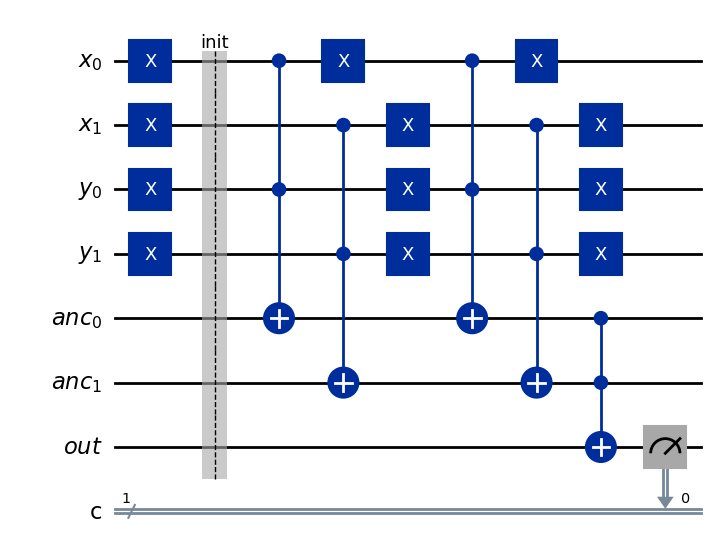

In [10]:
qc = string_eq("11","11")
qc.draw('mpl')

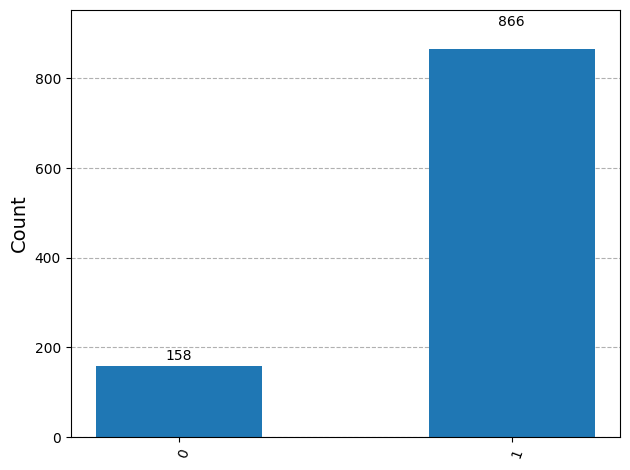

In [11]:
counts = fq.torino_run(qc)
plot_histogram(counts)

### Ottimizzazione

Osserviamo che 

$$
|00\rangle \to |01\rangle, \quad |11\rangle \to |11\rangle
$$

ma

$$
|01\rangle \to |00\rangle, \quad |10\rangle \to |10\rangle
$$

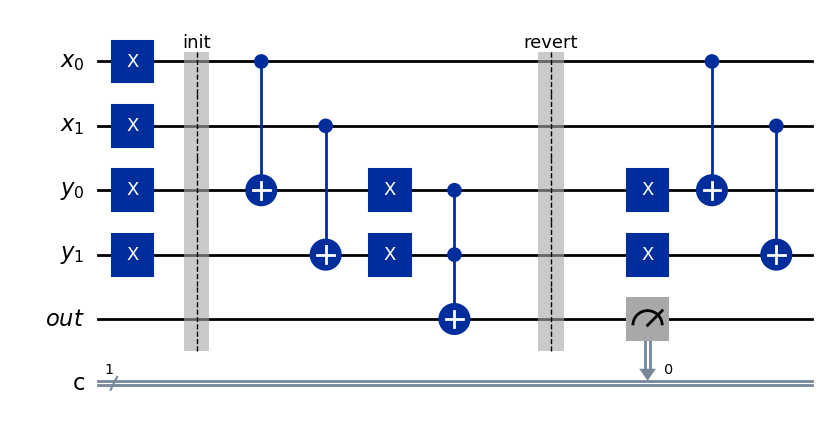

In [12]:
def string_eq(x,y):

    if (len(x) != len(y)):
        print("error")
        return
    
    n = len(x)
    xr = QuantumRegister(n, 'x')
    yr = QuantumRegister(n, 'y')
    out = QuantumRegister(1, 'out')
    cro = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(xr, yr, out, cro)
    for i in range(n):
        if x[i] == '1':
            qc.x(i)
        if y[i] == '1':
            qc.x(n+i)
        if x[i] == '+':
            qc.h(i)
        if y[i] == '+':
            qc.h(n+i)
    qc.barrier(label = 'init')


    for i in range(n):
        qc.cx(i, i+n)
        qc.x(i+n)
    qc.mcx(yr, out)

    qc.barrier(label = 'revert')
    for i in range(n):
        qc.x(i+n)
        qc.cx(i, i+n)

    qc.measure(out,cro[0])
    return qc

qc = string_eq("11","11")
qc.draw('mpl')

In [ ]:
counts = fq.torino_run(qc)
plot_histogram(counts)

### Esercizio 2: $f(x_1, x_2, x_3) = 1$ se almeno due sono = 1

Prima di scrivere l'esercizio, ragioniamo su ciò che vogliamo in output dal nostro programma in funzione degli input
```c
      [0]
000 -> 0
001 -> 0
010 -> 0
100 -> 0 

      [1]
011 -> 1
101 -> 1
110 -> 1
111 -> 1
```

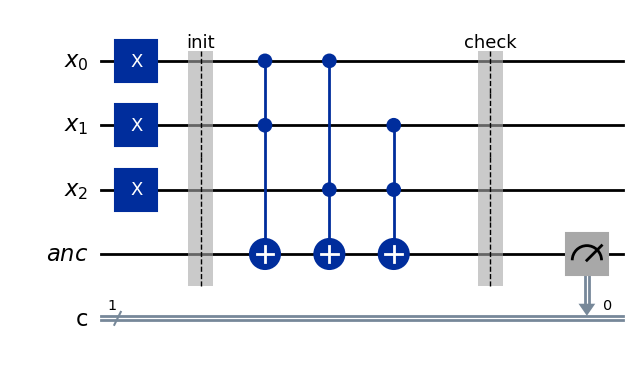

In [ ]:
def majority(x):
    if (len(x) != 3):
        print("error")
        return
    
    xr = QuantumRegister(3, 'x')
    anc = QuantumRegister(1, 'anc')
    cro = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(xr, anc, cro)
    for i in range(3):
        if x[i] == '1':
            qc.x(i)
        if x[i] == '+':
            qc.h(i)


    qc.barrier(label = 'init')
    qc.ccx(0,1,3)
    qc.ccx(0,2,3)
    qc.ccx(1,2,3)
    qc.barrier(label = 'check')
    qc.measure(anc,cro[0])
    return qc

qc = majority("111")
qc.draw('mpl')

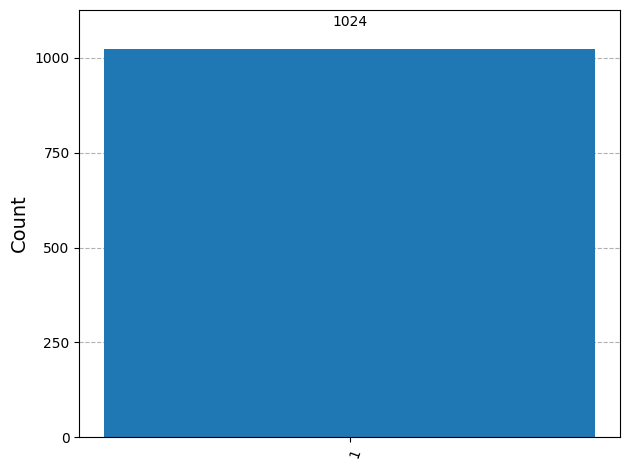

In [ ]:
counts = (fq.run(majority("101")))
plot_histogram(counts)

### Esercizio 3: $f(\overline{x}) = \overline{x}+1$ 

```c
000 -> 001
001 -> 010
010 -> 011
011 -> 100
100 -> 101
101 -> 110
110 -> 111
```

In [ ]:
# TODO

### Esercizio 4: distanza di Hamming

In [ ]:
# TODO

### Oracolo Booleano banale: $f(x) = 1 \ : x = 010 \lor x = 111$

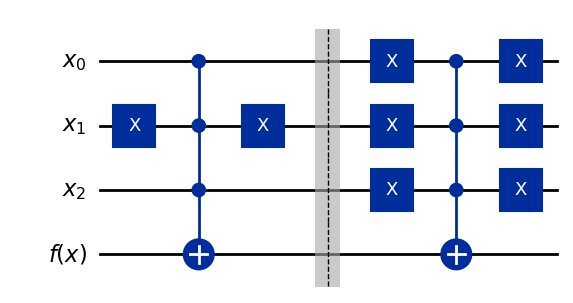

In [22]:
qr = QuantumRegister(3, 'x')
oqr = QuantumRegister(1, 'f(x)')
qc = QuantumCircuit(qr, oqr)

# first check
qc.x(1)
qc.mcx(list(range(3)), 3)
qc.x(1)

qc.barrier()
# second check
qc.x(range(3))
qc.mcx(list(range(3)), 3)
qc.x(range(3))
qc.draw('mpl')